In [ ]:
!pip install datasets
!pip install evaluate

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
)

import numpy as np
import tensorflow as tf
import torch
from datasets import Dataset, load_dataset, DatasetDict


import pandas as pd


In [ ]:
big_dataset_url = "hf://datasets/ESGBERT/environment_data/environment_data.csv"
dataset_url = "hf://datasets/ESGBERT/environmental_2k/environmental_2k.csv"
model_checkpoint = "google/bert_uncased_L-2_H-512_A-8"

"""Other models to try:
distilbert-base-uncased
"""

train_ratio = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device: ", device)


using device:  cuda


In [ ]:

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
mlm_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)



In [ ]:
tokenizer

BertTokenizerFast(name_or_path='google/bert_uncased_L-2_H-512_A-8', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [ ]:
"""sample model pipeline"""
sample = "test [MASK] some [MASK]thin [MASK]"

# Tokenize text
sample_tokenized = tokenizer([sample], return_tensors='pt', padding=True)
samp_out = mlm_model(**sample_tokenized)

print("output logits: ", samp_out.logits)

output logits:  tensor([[[ -9.4125,  -8.4637,  -9.1380,  ...,  -8.2152, -11.9307,  -7.7812],
         [ -9.7084,  -8.3756,  -8.8134,  ...,  -7.9416, -10.9808,  -8.9557],
         [ -8.2224,  -8.2958,  -7.6333,  ...,  -7.0930, -10.0589,  -4.0423],
         ...,
         [-10.0483, -10.6377,  -9.6757,  ...,  -8.6886, -10.9759,  -9.4402],
         [ -7.4171,  -9.1206,  -7.7921,  ...,  -8.2052,  -8.1394,  -6.1813],
         [ -8.9019,  -8.2693,  -7.9525,  ...,  -7.9172, -11.5575,  -7.4230]]],
       grad_fn=<ViewBackward0>)


In [ ]:
text = "This is a great [MASK]."


inputs = tokenizer(text, return_tensors="pt")
token_logits = mlm_model(**inputs).logits

# Find the location of [MASK] and extract its logits
mask_token_index = np.argwhere(inputs["input_ids"] == tokenizer.mask_token_id)[1, 0]
mask_token_logits = token_logits[0, mask_token_index, :]

# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.argsort(mask_token_logits, descending=True)[:5].tolist()

for token in top_5_tokens:
    print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")

>>> This is a great event.
>>> This is a great place.
>>> This is a great idea.
>>> This is a great thing.
>>> This is a great deal.


In [ ]:
"""Read environment dataset from ESGBERT (big and 2k labelled samples) from huggingface"""
df = pd.read_csv(dataset_url)[['text', 'env']]
df['env'] = df['env'].astype('int16')

df_big = pd.read_csv(big_dataset_url)#[['text']]

In [ ]:
df, df_big

,sentence
0,"Over the course of the year, your partnership ..."
1,Working with community and Indigenous-led coal...
2,And together we made a more inclusive conserva...
3,They also serve to remind us that we never hav...
4,You are a vital member of this movement to cre...
...,...
2100581,"However, we practice design for the environmen..."
2100582,ENVIRONMENTAL COMPLIANCE laws and regulations ...
2100583,CUSTOMER HEALTH AND SAFETY Assessment of the h...
2100584,We continually collect and analyze safety info...


In [ ]:
"""Arrow Dataset"""
class EnvDataset(Dataset):
    """ESG dataset."""
    def __init__(self, df:pd.DataFrame):
        """
        Arguments:
            df (Dataframe): dataframe to construct dataset from
        """
        self.df_dict=df.to_dict(orient='list')
        self.len = len(df.index)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return {
                k : v[idx] for k, v in self.df_dict.items()
            }

In [ ]:
train_size = 10_000 # select train_size based on resources; or just leave as ratio (eg. 0.8) to use entire dataset
test_size = int(0.1 * train_size)

ds = Dataset.from_pandas(df)
dataset = ds.train_test_split(train_size=train_ratio)

ds_big = Dataset.from_pandas(df_big)
dataset_big = ds_big.train_test_split(train_size=train_size, test_size=test_size)
dataset_big = dataset_big.rename_columns({'sentence': 'text'})


In [ ]:
samp = dataset['train'].shuffle().select(range(5))
for row in samp:
    print(f"text: {row['text']}, \nlabel: {row['env']}")

In [ ]:
samp_big = dataset_big['train'].shuffle().select(range(5))
for row in samp:
    print(f"text: {row['text']}")

txt: The Group has no outstanding grants under any equity incentive plan.  
txt: We monitor the effectiveness of our controls through our internal audit function, which is independent of the operating divisions and reports directly to the Audit Committee.  
txt: We have a strong commitment to the conservation of natural resources, water and energy.  
txt: The calculation of the severance payment is based on the annual compensation for the previous financial year and on the expected annual compensation for the current financial year, if applicable.
txt: It is working with a range of stakeholders to improve the social and environmental impact of its supply chain.  


In [ ]:
"""Input Preprocessing"""

# Tokenizing function
def tokenize_function(examples, text_field="text"):
    result = tokenizer(examples[text_field])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

# Process labels to make them multi-class (2 classes) for use of cross-entropy loss
def tupelize_labels(examples):
    result = examples
    result['label'] = [[val, 1-val] for val in examples['env']]
    return result

# Map transformations over datasets. Use batched=True to activate multithreading

# Prepare dataset for mlm pretraining--this only requires tokenized input text and the masked input ids and locations for labels
tokenized_datadict_for_mlm = dataset_big.map(
    tokenize_function, batched=True, remove_columns=["text"]
)

tokenized_dataset_classification = dataset.map(
    tokenize_function, batched=True, remove_columns=["text"]
)

tokenized_dataset_classification = tokenized_dataset_classification.map(
    tupelize_labels, batched=True
)

tokenized_datadict_for_mlm

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 1000
    })
})

In [ ]:
"""View train dataset"""
pd.DataFrame(tokenized_datadict_for_mlm['train']).head()

,input_ids,token_type_ids,attention_mask,word_ids
0,"[101, 2256, 2783, 3919, 2944, 2003, 7399, 1517...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."
1,"[101, 5678, 1010, 2138, 1997, 2572, 12870, 224...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 4, 4, 5, 6, 7, 8, 9, 10,..."
2,"[101, 1996, 3277, 14670, 1996, 3169, 1997, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."
3,"[101, 2129, 2057, 2147, 2004, 3625, 9387, 9181...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1..."
4,"[101, 2012, 2019, 2827, 2120, 2504, 1010, 1209...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[None, 0, 1, 2, 3, 4, 5, 6, 6, 7, 7, 8, 9, 10,..."


<Axes: >

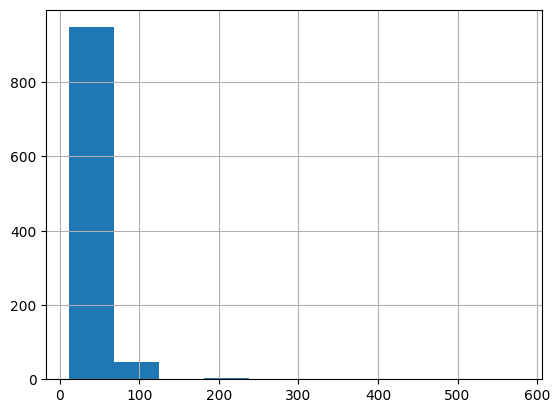

In [ ]:
"""Analyse distribution of token lengths for setences in the dataset"""
tst = pd.DataFrame(tokenized_datadict_for_mlm['test'])['input_ids'].apply(len)
tst.hist()

In [ ]:
"""Further data processing: group setnences into one long setnence and split into chunk-sized sentences"""
def get_stacked_dataset(dataset:Dataset, separator_tok=None, chunk_size=256):
    dataset_dict = dataset.to_dict() if isinstance(dataset, Dataset) else dataset
    stacked_len = len(np.hstack(dataset_dict[list(dataset_dict.keys())[0]]))
    dataset_dict = {
        k:np.hsplit(np.hstack(dataset_dict[k])[:-(stacked_len%chunk_size)], stacked_len//chunk_size) for k in dataset_dict
    } if separator_tok else {
        k:np.hsplit(np.hstack(dataset_dict[k])[:-(stacked_len%chunk_size)], stacked_len//chunk_size) for k in dataset_dict
    }
    dataset_dict['labels'] = dataset_dict['input_ids'].copy()
    return Dataset.from_dict(dataset_dict) if isinstance(dataset, Dataset) else dataset_dict

test = get_stacked_dataset(dataset=tokenized_datadict_for_mlm['test'])
len(test[-1]['input_ids'])


256

In [ ]:
"""Final dataset that we will be using to train and evaluate our model"""
tokenized_chunked_datadict = tokenized_datadict_for_mlm.map(get_stacked_dataset, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
"""Brief check of a sample's token length"""
print("token-length of a sentence: ", len(tokenized_chunked_datadict["train"][0]["input_ids"]))
# tokenized_chunked_datadict.

token-length of a sentence:  256


In [ ]:
from transformers import DataCollatorForLanguageModeling, DataCollatorForWholeWordMask, DefaultDataCollator, DataCollatorWithPadding#DataCollatorForSe

"""
Data collation--default functions that prepare our data into batches for training. They also
do additional tasks like word masking (for mlm objective) and padding
"""
mask_probability = 0.15

# Simple data collator for MLM objective (masks each token with given probability)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=mask_probability)

# Whole word masking (masks each word with given probability)
data_collator_wwm = DataCollatorForWholeWordMask(tokenizer=tokenizer, mlm_probability=mask_probability)

# Simple collator for our classification task (after pretraining)--just pads and batches input
data_collator_classification = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

In [ ]:
"""Sample data collating inputs and labels"""
example_batch_size = 2
samples = [tokenized_chunked_datadict["train"][i] for i in range(example_batch_size)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator_wwm(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")
for chunk in data_collator_wwm(samples)["labels"]:
    print(f"\n'>>> {chunk}'")


'>>> [CLS] our current industrial model flickering [MASK] — take, make, waste. [SEP] [CLS] additionally, because of ametek ’ s distributed occurred structure, business leaders are responsible for cocktail [MASK] managing, and working to [MASK] the environmental impact of their operations in [MASK] [MASK] ametek [MASK] s environmental targets. [SEP] [CLS] adelaide issue impacts the operation of the bank and the wider market, and may primarily affect its customers, shareholders [MASK] suppliers. [SEP] [CLS] how we work as responsible investors criteria related to the environment, social issues and corporate governance ( esg ) are integrated with [MASK] [MASK] [MASK] produce better background [MASK] for decisions in the investment process. [SEP] [CLS] at an australian national level, arrium submits annually a detailed [MASK] [MASK] [MASK] energy [MASK] scheme ( ngers ) report to the australian government [MASK] [SEP] [CLS] gibraltar [MASK] all suppliers to be in compliance with [MASK], l

In [ ]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(tokenized_chunked_datadict["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=False,
    use_cpu=(device==torch.device('cpu')),
    # fp16=True, # on gpu ..
    logging_steps=logging_steps,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

trainer_mlm = Trainer(
    model=mlm_model,
    args=training_args,
    train_dataset=tokenized_chunked_datadict["train"],
    eval_dataset=tokenized_chunked_datadict["test"],
    data_collator=data_collator_wwm, # experiment with the other data collator for masked language modelling
    tokenizer=tokenizer,
)

In [ ]:
"""Compute perplexity of model (prior to pretraining; this is just the BERT model checkpoint trained on natural language english)"""
import math

eval_results = trainer_mlm.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 43.26


In [ ]:
"""train model"""
trainer_mlm.train()

Epoch,Training Loss,Validation Loss
1,3.828800,3.549203
2,3.754300,3.561213
3,3.666400,3.426410


TrainOutput(global_step=66, training_loss=3.7477691245801523, metrics={'train_runtime': 53.7187, 'train_samples_per_second': 77.18, 'train_steps_per_second': 1.229, 'total_flos': 42030451390464.0, 'train_loss': 3.7477691245801523, 'epoch': 3.0})

In [ ]:
"""Evaluate perplexity again after training--is there an improvement?"""
eval_results = trainer_mlm.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 31.41


In [ ]:
# view model config
print(mlm_model.config)

# Save model (this is not the complete classifier, just the pretrained MLM model) FIXME uncomment save line for trying
mlm_model_dirname = f'saved_mlm_models/finetuned-{mlm_model.config.name_or_path.replace("google/", "")}'
# mlm_model_dirname.save_pretrained(mlm_model_dirname)

BertConfig {
  "_name_or_path": "google/bert_uncased_L-2_H-512_A-8",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
"""loading model and retreiving basemodel (encoder, without MLM head)"""
"""If loading saved model, uncomment"""
# loaded_mlm_model = AutoModelForMaskedLM.from_pretrained(mlm_model_dirname)
# base_model = loaded_model.base_model

base_model = mlm_model.base_model


In [ ]:
class BertClassifier(torch.nn.Module):
    def __init__(self, base_bert_model, num_classes=2):
        super(BertClassifier, self).__init__()

        # The base (pre-trained) bert encoder
        self.base_model = base_bert_model

        # Custom classification head
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(self.base_model.config.max_position_embeddings, num_classes) # output features from bert is 512 and 2 is ur number of labels

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids, attention_mask=attention_mask)

        outputs = self.dropout(outputs.last_hidden_state[:,0,:]) # This returns the last hidden state of the token corresponding to [CLS] (see BERT paper)
        outputs = self.linear(outputs)

        if labels is not None:
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(outputs.float(), labels.float())
            print("loss: ", loss)

        return (loss, outputs) if labels is not None else (outputs,)


In [ ]:
classifier_model = BertClassifier(base_bert_model=mlm_model.base_model)
classifier_model

BertClassifier(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elemen

In [ ]:
import numpy as np
import evaluate
from datasets import Value

metric = evaluate.load("accuracy")

# for accuracy:
def compute_metrics(eval_pred):
    labels, logits = eval_pred
    predictions = np.argmax(logits, axis=1)#torch.softmax(torch.tensor(logits).float(), dim=1)  #np.argmax(logits, axis=1)
    references = np.argmax(labels, axis=1)

    return metric.compute(predictions=(predictions), references=references)#(labels))

training_args_classifier = TrainingArguments(output_dir="train_out", eval_strategy="epoch", use_cpu=(device==torch.device('cpu')))
trainer_classifier = Trainer(
    model=classifier_model,
    args=training_args_classifier,
    train_dataset=tokenized_dataset_classification['train'],
    eval_dataset=tokenized_dataset_classification['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator_classification,
)



In [ ]:
"""Testing evaluate, before training the (randomly initialized) classification head"""
trainer_classifier.evaluate() # Accuracy will be around 50%, or around proportion of positively labelled data (random guessing)

loss:  tensor(0.7241, device='cuda:0')


loss:  tensor(0.6703, device='cuda:0')
loss:  tensor(0.6300, device='cuda:0')
loss:  tensor(0.6015, device='cuda:0')
loss:  tensor(0.7545, device='cuda:0')
loss:  tensor(0.6181, device='cuda:0')
loss:  tensor(0.6329, device='cuda:0')
loss:  tensor(0.6684, device='cuda:0')
loss:  tensor(0.7002, device='cuda:0')
loss:  tensor(0.6348, device='cuda:0')
loss:  tensor(0.6922, device='cuda:0')
loss:  tensor(0.6494, device='cuda:0')
loss:  tensor(0.7607, device='cuda:0')
loss:  tensor(0.7120, device='cuda:0')
loss:  tensor(0.6409, device='cuda:0')
loss:  tensor(0.6179, device='cuda:0')
loss:  tensor(0.7272, device='cuda:0')
loss:  tensor(0.6914, device='cuda:0')
loss:  tensor(0.5866, device='cuda:0')
loss:  tensor(0.6015, device='cuda:0')
loss:  tensor(0.5812, device='cuda:0')
loss:  tensor(0.6446, device='cuda:0')
loss:  tensor(0.5861, device='cuda:0')
loss:  tensor(0.6863, device='cuda:0')
loss:  tensor(0.7197, device='cuda:0')
loss:  tensor(0.5760, device='cuda:0')
loss:  tensor(0.8324, dev

{'eval_loss': 0.6833541989326477,
 'eval_accuracy': 0.5525,
 'eval_runtime': 0.3913,
 'eval_samples_per_second': 1022.163,
 'eval_steps_per_second': 127.77}

In [ ]:
trainer_classifier.train()

loss:  tensor(0.6657, device='cuda:0', grad_fn=<DivBackward1>)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.165420,0.952500
2,No log,0.165885,0.957500
3,0.264600,0.188699,0.957500


loss:  tensor(0.6349, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.6731, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7118, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(1.0595, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.5051, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.6712, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4126, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4312, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.3718, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(1.1379, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.6870, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.9152, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.4347, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.5410, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.8323, device='cuda:0', grad_fn=<DivBackward1>)
loss:  tensor(0.7014, device='cuda:0', grad_fn=<DivBack

loss:  tensor(0.0861, device='cuda:0')
loss:  tensor(0.0090, device='cuda:0')
loss:  tensor(0.0220, device='cuda:0')
loss:  tensor(0.0188, device='cuda:0')
loss:  tensor(0.0056, device='cuda:0')
loss:  tensor(0.0676, device='cuda:0')
loss:  tensor(0.5009, device='cuda:0')
loss:  tensor(0.0085, device='cuda:0')
loss:  tensor(0.1176, device='cuda:0')
loss:  tensor(0.0227, device='cuda:0')
loss:  tensor(0.0186, device='cuda:0')
loss:  tensor(0.0295, device='cuda:0')
loss:  tensor(0.1881, device='cuda:0')
loss:  tensor(0.9784, device='cuda:0')
loss:  tensor(0.0159, device='cuda:0')
loss:  tensor(0.0313, device='cuda:0')
loss:  tensor(0.1866, device='cuda:0')
loss:  tensor(0.1478, device='cuda:0')
loss:  tensor(0.0277, device='cuda:0')
loss:  tensor(0.7436, device='cuda:0')
loss:  tensor(0.0238, device='cuda:0')
loss:  tensor(0.2760, device='cuda:0')
loss:  tensor(0.0133, device='cuda:0')
loss:  tensor(0.0395, device='cuda:0')
loss:  tensor(0.0387, device='cuda:0')
loss:  tensor(0.0137, dev

TrainOutput(global_step=600, training_loss=0.2447416321436564, metrics={'train_runtime': 19.0762, 'train_samples_per_second': 251.623, 'train_steps_per_second': 31.453, 'total_flos': 0.0, 'train_loss': 0.2447416321436564, 'epoch': 3.0})

In [ ]:
classifier_model.eval()
trainer_classifier.evaluate()

loss:  tensor(0.0008, device='cuda:0')


loss:  tensor(0.0119, device='cuda:0')
loss:  tensor(0.0018, device='cuda:0')
loss:  tensor(0.0022, device='cuda:0')
loss:  tensor(0.0010, device='cuda:0')
loss:  tensor(0.0004, device='cuda:0')
loss:  tensor(0.0160, device='cuda:0')
loss:  tensor(0.7073, device='cuda:0')
loss:  tensor(0.0009, device='cuda:0')
loss:  tensor(0.2214, device='cuda:0')
loss:  tensor(0.0024, device='cuda:0')
loss:  tensor(0.0012, device='cuda:0')
loss:  tensor(0.0082, device='cuda:0')
loss:  tensor(0.0062, device='cuda:0')
loss:  tensor(1.4543, device='cuda:0')
loss:  tensor(0.0036, device='cuda:0')
loss:  tensor(0.0007, device='cuda:0')
loss:  tensor(0.0425, device='cuda:0')
loss:  tensor(0.3914, device='cuda:0')
loss:  tensor(0.0026, device='cuda:0')
loss:  tensor(0.9607, device='cuda:0')
loss:  tensor(0.0191, device='cuda:0')
loss:  tensor(0.2651, device='cuda:0')
loss:  tensor(0.0040, device='cuda:0')
loss:  tensor(0.0094, device='cuda:0')
loss:  tensor(0.0219, device='cuda:0')
loss:  tensor(0.0010, dev

{'eval_loss': 0.1886991560459137,
 'eval_accuracy': 0.9575,
 'eval_runtime': 0.3939,
 'eval_samples_per_second': 1015.392,
 'eval_steps_per_second': 126.924,
 'epoch': 3.0}

In [ ]:
def process_model_input_for_inference(input, tokenizer):
    tokenized = tokenizer(input)
    return {'input_ids':torch.tensor([tokenized['input_ids']]).to(device), 'attention_mask':torch.tensor([tokenized['attention_mask']])}


In [ ]:
sample_inputs = ["in the last quarter we upped our social impact by a lot",
                 "in the last quarter we upped our environmental impact by a lot",
                 "some random sentence",
                 "this is related to environmental governence.",
                 'That’s why our strategy looks much more holistically at the health of local watersheds.',
                 'To achieve our commitment, we begin by assessing wages across all operating companies against the Fair Wage Network and aim to close any wage gaps by the end of 2023.',
                 'We are committed to maintaining and enhancing our reputation for responsible business practices and will continue to promote our standards in line with our Business Principles.',
                 'this is a terrible work environment.',
                 'a great environment for work',
                 'our work is terrible for the environment. We hate the environment.']

for inp in sample_inputs:
    # Remember model was trained on outputs that look like [1, 0] for 1 and [0, 1] for 0
    print(f'{inp}: {1-np.argmax(classifier_model(**process_model_input_for_inference(inp, tokenizer=tokenizer))[0].detach().cpu().numpy())}')


in the last quarter we upped our social impact by a lot: 0
in the last quarter we upped our environmental impact by a lot: 1
some random sentence: 0
this is related to environmental governence.: 1
That’s why our strategy looks much more holistically at the health of local watersheds.: 1
To achieve our commitment, we begin by assessing wages across all operating companies against the Fair Wage Network and aim to close any wage gaps by the end of 2023.: 0
We are committed to maintaining and enhancing our reputation for responsible business practices and will continue to promote our standards in line with our Business Principles.: 0
this is a terrible work environment.: 0
a great environment for work: 0
our work is terrible for the environment. We hate the environment.: 1


In [ ]:
# Save classifier model FIXME uncomment to use
# torch.save(classifier_model, 'saved_classifier_models/my_esg_env_classifier_1')